In [1]:
!git clone https://ctlab.itmo.ru/gitlab/eabelyaev/cnnimagecodec.git

Cloning into 'cnnimagecodec'...
remote: Enumerating objects: 280, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 280 (delta 16), reused 252 (delta 3), pack-reused 0
Receiving objects: 100% (280/280), 11.51 MiB | 6.50 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [2]:
!pip install pybind11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 1.8 MB/s eta 0:00:00


In [1]:
!pip install setuptools==58.1.0

In [6]:
cd cnnimagecodec

[Errno 2] No such file or directory: 'cnnimagecodec'
/content/cnnimagecodec


In [4]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [7]:
!wget https://raw.githubusercontent.com/Myashka/Codec_ITMO_lab/main/EntropySetup.py

--2024-05-13 17:53:55--  https://raw.githubusercontent.com/Myashka/Codec_ITMO_lab/main/EntropySetup.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318 [text/plain]
Saving to: ‘EntropySetup.py’

EntropySetup.py     100%[===================>]     318  --.-KB/s    in 0s      

2024-05-13 17:53:56 (3.58 MB/s) - ‘EntropySetup.py’ saved [318/318]



In [8]:
!python EntropySetup.py build_ext --inplace

running build_ext
building 'EntropyCodec' extension
creating build
creating build/temp.linux-x86_64-3.10
x86_64-linux-gnu-gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.10/dist-packages/pybind11/include -I/usr/include/python3.10 -c wrapper.cpp -o build/temp.linux-x86_64-3.10/wrapper.o
In file included from wrapper.cpp:5:
ImageCoder.cpp: In function ‘int BitPlaneEncoder(unsigned char*, unsigned char*, int, int, int, int*)’:
ImageCoder.cpp:21:38: warning: ISO C++ forbids converting a string constant to ‘char*’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wwrite-strings-Wwrite-strings]8;;]
   21 |         biari_init_context(&bin_ctx, "ctx");
      |                                      ^~~~~
ImageCoder.cpp: In function ‘int BitPlaneDecoder(unsign

In [9]:
ls

ac_dec.cpp        doc/                             EntropySetup.py    README.md         train/
ac_enc.cpp        encoder.mdl/                     EntropySetup.py.1  requirements.txt  wrapper.cpp
CNNImageCodec.py  EntropyCodec.cp39-win_amd64.pyd  ImageCoder.cpp     stream.h
decoder.mdl/      EntropyCompile.bat               mcoder.h           test/


In [12]:
!python EntropySetup.py build_ext --inplace
!pip install .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [10]:
#This code is the simplest example of image compression based on neural networks
#Comparison with JPEG is provided as well
#It is a demonstation for Information Theory course
#Written by Evgeny Belyaev, February 2024.
import os
import math
import numpy
from matplotlib import pyplot as plt
from PIL import Image
import imghdr
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras import backend as K

#import C-implementation of Witten&Neal&Cleary-1987 arithmetic coding as a external module
from EntropyCodec import *

#source folder with test images
testfolder = './test/'
#source folder with train images
trainfolder = './train/'
#size of test and train images
w=128
h=128
#If 0, then the training will be started, otherwise the model will be readed from a file
#LoadModel = 1
#Training parameters
batch_size = 10
#Number of bits for representation of the layers sample in the training process
bt = 3
epochs = 3000
#epochs = 100
#Model parameters
n1=128
n2=32
n3=16

#Number of images to be compressed and shown from the test folder
NumImagesToShow = 5

#Number of bits for representation of the layers sample
b = 3


In [9]:
import EntropyCodec

In [11]:
def PSNR_RGB(image1,image2):
    width, height = image1.size
    I1 = numpy.array(image1.getdata()).reshape(image1.size[0], image1.size[1], 3)
    I2 = numpy.array(image2.getdata()).reshape(image2.size[0], image2.size[1], 3)
    I1 = numpy.reshape(I1, width * height * 3)
    I2 = numpy.reshape(I2, width * height * 3)
    I1 = I1.astype(float)
    I2 = I2.astype(float)
    mse = numpy.mean((I1 - I2) ** 2)
    if (mse == 0):  # MSE is zero means no noise is present in the signal .
        psnr=100.0
    else:
        max_pixel = 255.0
        psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    #print("PSNR = %5.2f dB" % psnr)
    return psnr

#Compute PSNR between two vectors
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * (1.0 / math.log(10)) * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))

#reads all images from folder and puts them into x array
def LoadImagesFromFolder (foldername):
    dir_list = os.listdir(foldername)
    N = 0
    Nmax = 0
    for name in dir_list:
        fullname = foldername + name
        filetype = imghdr.what(fullname)
        if filetype is None:
            print('')
        else:
            Nmax = Nmax + 1

    x = numpy.zeros([Nmax, w, h, 3])
    N = 0
    for name in dir_list:
        fullname = foldername + name
        filetype = imghdr.what(fullname)
        if filetype is None:
            print('Unknown image format for file: ', name)
        else:
            print('Progress: N = %i' % N)
            image = Image.open(fullname)
            I1 = numpy.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
            x[N, :, :, :] = I1
            N = N + 1
    return x

#Model training function
# def ImageCodecModel(trainfolder):
#     input = layers.Input(shape=(w, h, 3))
#     # Encoder
#     e1 = layers.Conv2D(n1, (7, 7), activation="relu", padding="same")(input)
#     e1 = layers.MaxPooling2D((2, 2), padding="same")(e1)
#     e2 = layers.Conv2D(n2, (5, 5), activation="relu", padding="same")(e1)
#     e2 = layers.MaxPooling2D((2, 2), padding="same")(e2)
#     e3 = layers.Conv2D(n3, (3, 3), activation="relu", padding="same")(e2)
#     e3 = layers.MaxPooling2D((2, 2), padding="same")(e3)
#     #add noise during training (needed for layer quantinzation)
#     e3 = e3 + tensorflow.random.uniform(tensorflow.shape(e3), 0, tensorflow.math.reduce_max(e3)/pow(2, bt+1))

#     # Decoder
#     x = layers.Conv2DTranspose(n3, (3, 3), strides=2, activation="relu", padding="same")(e3)
#     x = layers.Conv2DTranspose(n2, (5, 5), strides=2, activation="relu", padding="same")(x)
#     x = layers.Conv2DTranspose(n1, (7, 7), strides=2, activation="relu", padding="same")(x)
#     x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

#     # Autoencoder
#     encoder = Model(input, e3)
#     decoder = Model(e3, x)
#     autoencoder = Model(input, x)
#     autoencoder.compile(optimizer="adam", loss='mean_squared_error')
#     autoencoder.summary()

#     if LoadModel == 0:
#         xtrain = LoadImagesFromFolder(trainfolder)
#         xtrain = xtrain / 255
#         autoencoder.fit(xtrain, xtrain, epochs=epochs, batch_size=batch_size,shuffle=True)
#         autoencoder.save('autoencodertemp.mdl')
#         encoder.save('encoder.mdl')
#         decoder.save('decoder.mdl')
#     else:
#         autoencoder = keras.models.load_model('autoencodertemp.mdl')
#         encoder = keras.models.load_model('encoder.mdl')
#         decoder = keras.models.load_model('decoder.mdl')
#     return encoder,decoder

#Compresses input layer by multi-alphabet arithmetic coding using memoryless source model
def EntropyEncoder (filename,enclayers,size_z,size_h,size_w):
    temp = numpy.zeros((size_z, size_h, size_w), numpy.uint8, 'C')
    for z in range(size_z):
        for h in range(size_h):
            for w in range(size_w):
                temp[z][h][w] = enclayers[z][h][w]
    maxbinsize = (size_h * size_w * size_z)
    bitstream = numpy.zeros(maxbinsize, numpy.uint8, 'C')
    StreamSize = numpy.zeros(1, numpy.int32, 'C')
    HiddenLayersEncoder(temp, size_w, size_h, size_z, bitstream, StreamSize)
    name = filename
    path = './'
    fp = open(os.path.join(path, name), 'wb')
    out = bitstream[0:StreamSize[0]]
    out.astype('uint8').tofile(fp)
    fp.close()

#Decompresses input layer by multi-alphabet arithmetic coding using memoryless source model
def EntropyDecoder (filename,size_z,size_h,size_w):
    fp = open(filename, 'rb')
    bitstream = fp.read()
    fp.close()
    bitstream = numpy.frombuffer(bitstream, dtype=numpy.uint8)
    declayers = numpy.zeros((size_z, size_h, size_w), numpy.uint8, 'C')
    FrameOffset = numpy.zeros(1, numpy.int32, 'C')
    FrameOffset[0] = 0
    HiddenLayersDecoder(declayers, size_w, size_h, size_z, bitstream, FrameOffset)
    return declayers

#This function is searching for the JPEG quality factor (QF)
#which provides neares compression to TargetBPP
def JPEGRDSingleImage(X,TargetBPP,i):
    X = X*255
    image = Image.fromarray(X.astype('uint8'), 'RGB')
    width, height = image. size
    realbpp = 0
    realpsnr = 0
    realQ = 0
    for Q in range(101):
        image.save('test.jpeg', "JPEG", quality=Q)
        image_dec = Image.open('test.jpeg')
        bytesize = os.path.getsize('test.jpeg')
        bpp = bytesize*8/(width*height)
        psnr = PSNR_RGB(image, image_dec)
        if abs(realbpp-TargetBPP)>abs(bpp-TargetBPP):
            realbpp=bpp
            realpsnr=psnr
            realQ = Q
    JPEGfilename = 'image%i.jpeg' % i
    image.save(JPEGfilename, "JPEG", quality=realQ)
    return realQ, realbpp, realpsnr


In [12]:
testfolder = './test/'

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import glob
from tqdm.auto import tqdm

In [290]:
test_imgs = glob.glob('test/*.png')
train_imgs = glob.glob('train/*.png')

In [15]:
class ImageCodec:
    def __init__(self):
        self.pca = None
        self.n = None
        self.m = None
        self.img_size = None #(N, M, K)
        self.min_max = None

    def set_shape(self, image):
        if self.img_size is None:
            self.img_size = image.shape
        assert(image.shape == self.img_size)

    def split_transform(self, image):
        N, M, K = self.img_size
        X = image.transpose((1,2,0)).reshape((M, K, N // self.n, self.n)) \
                     .transpose((1,2,3,0)).reshape((K, N // self.n, self.n, M // self.m, self.m)) \
                     .transpose((1,3,2,4,0)).reshape((N * M // (self.n * self.m), self.n * self.m * K))
        return X

    def get_min_max_scale(self):
        X = np.ones((2,self.n * self.m * self.img_size[2]))
        X[1]*=0
        Y = self.pca.transform(X)
        self.min_max = (Y.min(), Y.max())


    def train(self, train_imgs, n_components = 16, n = 8, m = 8):
        self.n = n
        self.m = m
        train_data = []
        for f in tqdm(train_imgs):
            image = plt.imread(f)
            self.set_shape(image)
            train_data.append(self.split_transform(image))
        train_data = np.concatenate(train_data)
        print(train_data.shape)
        self.pca = PCA(n_components=n_components)
        self.pca.fit(train_data)
        self.get_min_max_scale()


    def encode_decode(self, image, draw_picture=True, draw_decoded=True):
        self.set_shape(image)
        figsize = (2.5,2.5)
        if draw_picture:
            plt.figure(figsize=figsize)
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        X = self.split_transform(image)

        Y = self.pca.transform(X) # encode
        #print(f'Compressed vectors shape: {Y.shape}')
        #Y = (Y * 1e10).astype(np.int16).astype(np.float16) / 1e10
        Y = (Y - self.min_max[0]) / (self.min_max[1] - self.min_max[0])
        Y = (Y*5e2).astype(int).astype(np.float16) / 5e2
        Y = Y * (self.min_max[1] - self.min_max[0]) + self.min_max[0]
        #Y = (Y*1e1).astype(int).astype(np.float16) / 1e1
        X_hat = self.pca.inverse_transform(Y) # decode

        max_value = X.max()
        X_hat = X_hat * (X_hat <= max_value) + max_value * (X_hat > max_value)
        X_hat = X_hat * (X_hat >= 0) / max_value

        N, M, K = self.img_size
        X_hat = X_hat.reshape((N // self.n, M // self.m, self.n, self.m, K)).transpose((1,3,4,0,2)) \
                     .reshape((M // self.m, self.m, K, N)).transpose((3,2,0,1)) \
                     .reshape((N, K, M)).transpose((0,2,1))
        if draw_decoded:
            plt.figure(figsize=figsize)
            plt.imshow(X_hat)
            plt.axis('off')
            plt.show()
        return dict(enc=Y, dec=X_hat)

In [291]:
test_imgs

['test/9.png',
 'test/2.png',
 'test/13.png',
 'test/10.png',
 'test/21.png',
 'test/17.png',
 'test/7.png',
 'test/19.png',
 'test/16.png',
 'test/4.png',
 'test/12.png',
 'test/6.png',
 'test/18.png',
 'test/8.png',
 'test/20.png',
 'test/15.png',
 'test/1.png',
 'test/11.png',
 'test/14.png',
 'test/3.png',
 'test/5.png']

In [292]:
xtest = LoadImagesFromFolder(testfolder)
xtest = xtest / 255

Progress: N = 0
Progress: N = 1
Progress: N = 2
Progress: N = 3
Progress: N = 4
Progress: N = 5
Progress: N = 6
Progress: N = 7
Progress: N = 8
Progress: N = 9
Progress: N = 10
Progress: N = 11
Progress: N = 12
Progress: N = 13
Progress: N = 14
Progress: N = 15
Progress: N = 16
Progress: N = 17
Progress: N = 18
Progress: N = 19
Progress: N = 20


In [293]:
xtest.shape

(21, 128, 128, 3)

In [16]:
from keras import backend as Ke

In [17]:
codec = ImageCodec()

In [252]:
codec = ImageCodec()
n_components=35
n_t = 16
m_t = 16
codec.train(train_imgs, n_components = n_components, n = n_t, m = m_t)

  0%|          | 0/204 [00:00<?, ?it/s]

(13056, 768)


In [253]:
sorted(test_imgs)

['test/1.png',
 'test/10.png',
 'test/11.png',
 'test/12.png',
 'test/13.png',
 'test/14.png',
 'test/15.png',
 'test/16.png',
 'test/17.png',
 'test/18.png',
 'test/19.png',
 'test/2.png',
 'test/20.png',
 'test/21.png',
 'test/3.png',
 'test/4.png',
 'test/5.png',
 'test/6.png',
 'test/7.png',
 'test/8.png',
 'test/9.png']

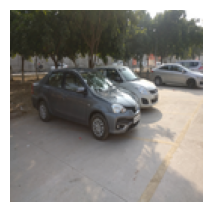

In [269]:
image = plt.imread(sorted(test_imgs)[1])

figsize = (2.5,2.5)
plt.figure(figsize=figsize)
plt.imshow(image)
plt.axis('off')
plt.show()

In [270]:
X = codec.split_transform(image)

Y = codec.pca.transform(X) # encode
#print(f'Compressed vectors shape: {Y.shape}')
#Y = (Y*5e2).astype(int).astype(np.float32) / 5e2
#Y = (Y*1e2).astype(int).astype(np.float32) / 1e2
#Y = Y.astype(np.float16)
Y = (Y - codec.min_max[0]) / (codec.min_max[1] - codec.min_max[0])

In [271]:
len(sorted((set(Y.flatten()))))

2235

In [272]:
#plt.hist(Y.flatten(), bins=len(sorted((set(Y.flatten())))))

In [273]:
b=7

In [274]:
sh0 = int((128*128/n_t/m_t)**(1/2))
sh0

8

In [275]:
#Run the model for first NumImagesToShow images from the test set
#encoded_layers = encoder.predict(xtest, batch_size=NumImagesToShow)
NumImagesToShow = 1
encoded_layers = Y.reshape(1,sh0,sh0,n_components)
max_encoded_layers = numpy.zeros(NumImagesToShow, numpy.float16, 'C')

#normalization the layer to interval [0,1)
for i in range(NumImagesToShow):
    max_encoded_layers[i] = numpy.max(encoded_layers[i])
    encoded_layers[i] = encoded_layers[i] / max_encoded_layers[i]

#Quantization of layer to b bits
encoded_layers1 = numpy.clip(encoded_layers, 0, 0.9999999)
encoded_layers1 = Ke.cast(encoded_layers1*pow(2, b), "int32")

#Encoding and decoding of each quantized layer by arithmetic coding
bpp = numpy.zeros(NumImagesToShow, numpy.float16, 'C')
declayers = numpy.zeros((NumImagesToShow,sh0, sh0, n_components), numpy.uint8, 'C')
for i in range(NumImagesToShow):
    binfilename = 'image%i.bin' % i
    EntropyEncoder(binfilename, encoded_layers1[i], sh0, sh0, n_components)
    bytesize = os.path.getsize(binfilename)
    bpp[i] = bytesize * 8 / (w * h)
    declayers[i] = EntropyDecoder(binfilename,  sh0, sh0, n_components)

#Dequantization and denormalization of each layer
print(bpp)

[0.4688]


In [276]:
#encoded_layers = None
#encoded_layers1 = None

In [277]:
shift = 1.0/pow(2, b+1)
declayers = Ke.cast(declayers, "float32") / pow(2, b)
declayers = declayers + shift

In [278]:
encoded_layers_quantized = numpy.zeros((NumImagesToShow, sh0, sh0, n_components), numpy.double, 'C')
for i in range(NumImagesToShow):
    encoded_layers_quantized[i] = Ke.cast(declayers[i]*max_encoded_layers[i], "float32")
    encoded_layers[i] = Ke.cast(encoded_layers[i] * max_encoded_layers[i], "float32")

In [279]:
#Y = (Y * 1e10).astype(int).astype(np.float32) / 1e10
#1e10 - 0.3857
#5e2 - 0.3848
bpp

array([0.4688], dtype=float16)

In [280]:
#Y_d = declayers.numpy().reshape(256, 16)#encoded_layers.reshape(256, 16)
Y_d = encoded_layers_quantized.reshape(sh0*sh0, n_components)
#Y_d = Y#encoded_layers_quantized.reshape(256, 16)

In [281]:
len(sorted((set(Y_d.flatten()))))

67

(array([3.00e+00, 0.00e+00, 0.00e+00, 4.00e+00, 1.00e+00, 1.00e+00,
        0.00e+00, 1.00e+00, 4.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 2.00e+00, 2.00e+00, 1.00e+00, 2.00e+00, 0.00e+00,
        1.00e+00, 3.00e+00, 1.00e+00, 5.00e+00, 1.00e+00, 3.00e+00,
        0.00e+00, 0.00e+00, 3.00e+00, 1.50e+01, 3.50e+01, 2.70e+01,
        1.44e+02, 2.01e+02, 1.44e+03, 1.48e+02, 9.50e+01, 2.50e+01,
        1.80e+01, 7.00e+00, 8.00e+00, 3.00e+00, 1.00e+00, 8.00e+00,
        0.00e+00, 3.00e+00, 0.00e+00, 1.00e+00, 2.00e+00, 4.00e+00,
        2.00e+00, 1.00e+00, 4.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 2.00e+00,
        2.00e+00]),
 array([0.14943886, 0.1593097 , 0.16918054, 0.17905138, 0.18892223,
        0.19879307, 0.20866391, 0.21853475, 0.2284056 , 0.23827644,
        0.24814728, 0.25801812, 0.26788897, 0.27775981, 0.28763065,
        0.29750149, 0.307372

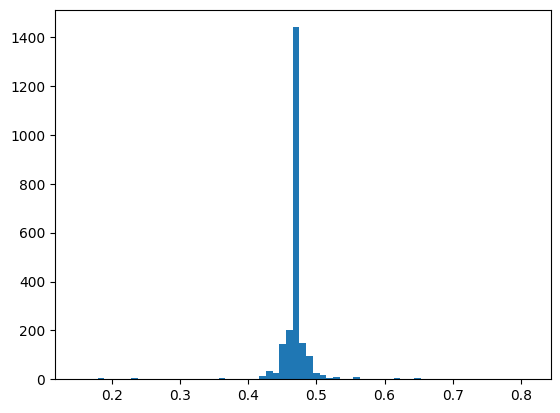

In [282]:
plt.hist(Y_d.flatten(), bins=len(sorted((set(Y_d.flatten())))))

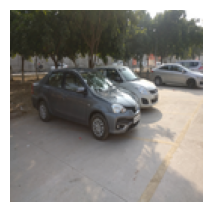

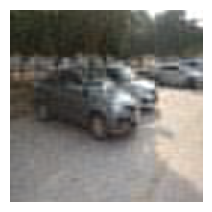

In [283]:
Y_hat = Y_d * (codec.min_max[1] - codec.min_max[0]) + codec.min_max[0]
        #Y = (Y*1e1).astype(int).astype(np.float16) / 1e1
X_hat = codec.pca.inverse_transform(Y_hat) # decode

max_value = X.max()
X_hat = X_hat * (X_hat <= max_value) + max_value * (X_hat > max_value)
X_hat = X_hat * (X_hat >= 0) / max_value

N, M, K = codec.img_size
X_hat = X_hat.reshape((N // codec.n, M // codec.m, codec.n, codec.m, K)).transpose((1,3,4,0,2)) \
                .reshape((M // codec.m, codec.m, K, N)).transpose((3,2,0,1)) \
                .reshape((N, K, M)).transpose((0,2,1))

figsize = (2.5,2.5)

plt.figure(figsize=figsize)
plt.imshow(image)
plt.axis('off')
plt.show()

plt.figure(figsize=figsize)
plt.imshow(X_hat)
plt.axis('off')
plt.show()

In [345]:
test_imgs = glob.glob('test/*.png')
train_imgs = glob.glob('train/*.png')

In [346]:
codec = ImageCodec()
n_components=35
n_t = 16
m_t = 16
codec.train(train_imgs, n_components = n_components, n = n_t, m = m_t)

  0%|          | 0/204 [00:00<?, ?it/s]

(13056, 768)


In [347]:
b=7

In [348]:
test_imgs = sorted(test_imgs)

In [349]:
#NumImagesToShow = 5
# xtest = np.concatenate([plt.imread(f) for f in test_imgs[:NumImagesToShow]]).reshape(-1, 128, 128, 3)
# xtest.shape

Number of unique PCAed values 2237
BPP [0.503]
Number of unique quantized values 65


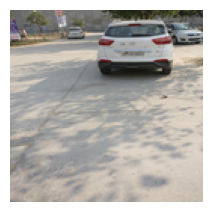

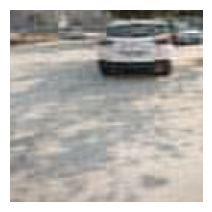

Number of unique PCAed values 2239
BPP [0.4688]
Number of unique quantized values 67


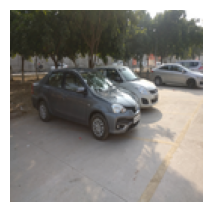

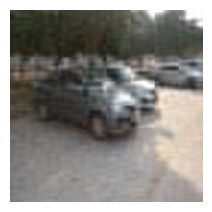

Number of unique PCAed values 2237
BPP [0.4937]
Number of unique quantized values 67


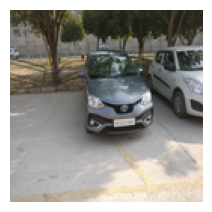

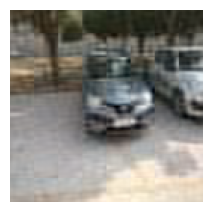

Number of unique PCAed values 2232
BPP [0.511]
Number of unique quantized values 63


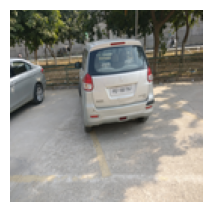

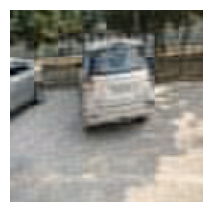

Number of unique PCAed values 2237
BPP [0.4863]
Number of unique quantized values 66


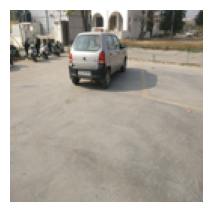

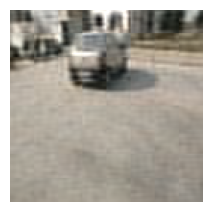

In [350]:
xtest = []
#decoded_imgs = []
decoded_imgsQ = []
bpps = []
for f in test_imgs[:5]:
# for image in xtest[:5]:
    image = plt.imread(f)
    xtest.append(image)

    X = codec.split_transform(image)

    Y = codec.pca.transform(X) # encode
    Y = (Y - codec.min_max[0]) / (codec.min_max[1] - codec.min_max[0])

    l_un = len(sorted((set(Y.flatten()))))
    print('Number of unique PCAed values', l_un)

    # if l_un < 1500:
    #     _ = plt.hist(Y.flatten(), bins=len(sorted((set(Y.flatten())))))

    sh0 = int((128*128/n_t/m_t)**(1/2))

    #Run the model for first NumImagesToShow images from the test set
    #encoded_layers = encoder.predict(xtest, batch_size=NumImagesToShow)
    NumImagesToShow = 1
    encoded_layers = Y.reshape(1,sh0,sh0,n_components)
    max_encoded_layers = numpy.zeros(NumImagesToShow, numpy.float16, 'C')

    #normalization the layer to interval [0,1)
    for i in range(NumImagesToShow):
        max_encoded_layers[i] = numpy.max(encoded_layers[i])
        encoded_layers[i] = encoded_layers[i] / max_encoded_layers[i]

    #Quantization of layer to b bits
    encoded_layers1 = numpy.clip(encoded_layers, 0, 0.9999999)
    encoded_layers1 = Ke.cast(encoded_layers1*pow(2, b), "int32")

    #Encoding and decoding of each quantized layer by arithmetic coding
    bpp = numpy.zeros(NumImagesToShow, numpy.float16, 'C')
    declayers = numpy.zeros((NumImagesToShow,sh0, sh0, n_components), numpy.uint8, 'C')
    for i in range(NumImagesToShow):
        binfilename = 'image%i.bin' % i
        EntropyEncoder(binfilename, encoded_layers1[i], sh0, sh0, n_components)
        bytesize = os.path.getsize(binfilename)
        bpp[i] = bytesize * 8 / (w * h)
        declayers[i] = EntropyDecoder(binfilename,  sh0, sh0, n_components)

    #Dequantization and denormalization of each layer
    print("BPP", bpp)
    bpps.append(bpp)

    shift = 1.0/pow(2, b+1)
    declayers = Ke.cast(declayers, "float32") / pow(2, b)
    declayers = declayers + shift

    encoded_layers_quantized = numpy.zeros((NumImagesToShow, sh0, sh0, n_components), numpy.double, 'C')
    for i in range(NumImagesToShow):
        encoded_layers_quantized[i] = Ke.cast(declayers[i]*max_encoded_layers[i], "float32")
        encoded_layers[i] = Ke.cast(encoded_layers[i] * max_encoded_layers[i], "float32")

    Y_d = encoded_layers_quantized.reshape(sh0*sh0, n_components)


    l_q = len(sorted((set(Y_d.flatten()))))
    print('Number of unique quantized values', l_q)

    #_ = plt.hist(Y_d.flatten(), bins=len(sorted((set(Y_d.flatten())))))

    Y_hat = Y_d * (codec.min_max[1] - codec.min_max[0]) + codec.min_max[0]
            #Y = (Y*1e1).astype(int).astype(np.float16) / 1e1
    X_hat = codec.pca.inverse_transform(Y_hat) # decode

    max_value = X.max()
    X_hat = X_hat * (X_hat <= max_value) + max_value * (X_hat > max_value)
    X_hat = X_hat * (X_hat >= 0) / max_value

    N, M, K = codec.img_size
    X_hat = X_hat.reshape((N // codec.n, M // codec.m, codec.n, codec.m, K)).transpose((1,3,4,0,2)) \
                    .reshape((M // codec.m, codec.m, K, N)).transpose((3,2,0,1)) \
                    .reshape((N, K, M)).transpose((0,2,1))

    decoded_imgsQ.append(X_hat)

    figsize = (2.5,2.5)

    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=figsize)
    plt.imshow(X_hat)
    plt.axis('off')
    plt.show()

In [351]:
NumImagesToShow = 5

In [352]:
xtest = np.concatenate(xtest).reshape(-1,128,128,3)
decoded_imgsQ = np.concatenate(decoded_imgsQ).reshape(-1,128,128,3)
bpps = np.concatenate(bpps)

In [353]:
from keras import backend as K

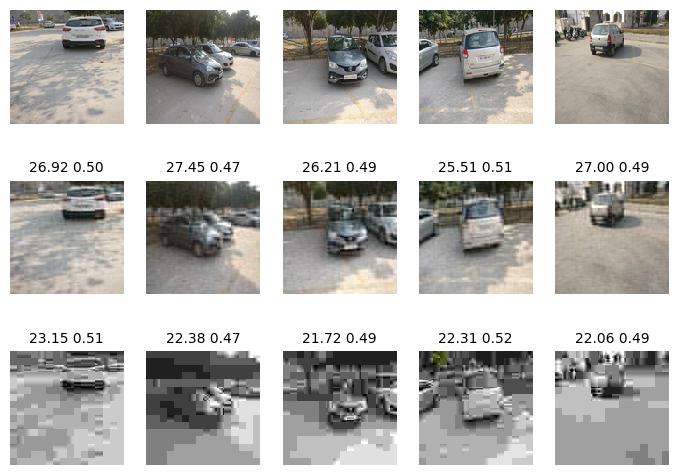

In [365]:
figsize = (8.5,8.5)
plt.figure(figsize=figsize)
for i in range(NumImagesToShow):
    title = ''
    plt.subplot(4, NumImagesToShow, i + 1).set_title(title, fontsize=10)
    plt.imshow(xtest[i, :, :, :], interpolation='nearest')
    plt.axis(False)
# for i in range(NumImagesToShow):
#     psnr = PSNR(xtest[i, :, :, :], decoded_imgs[i, :, :, :])
#     title = '%2.2f' % psnr
#     plt.subplot(4, NumImagesToShow, NumImagesToShow + i + 1).set_title(title, fontsize=10)
#     plt.imshow(decoded_imgs[i, :, :, :], interpolation='nearest')
#     plt.axis(False)
for i in range(NumImagesToShow):
    psnr = PSNR(xtest[i, :, :, :], decoded_imgsQ[i, :, :, :])
    title = '%2.2f %2.2f' % (psnr, bpps[i])
    plt.subplot(4, NumImagesToShow, 1*NumImagesToShow + i + 1).set_title(title, fontsize=10)
    plt.imshow(decoded_imgsQ[i, :, :, :], interpolation='nearest')
    plt.axis(False)
for i in range(NumImagesToShow):
    JPEGQP,JPEGrealbpp, JPEGrealpsnr = JPEGRDSingleImage(xtest[i, :, :, :], bpps[i],i)
    JPEGfilename = 'image%i.jpeg' % i
    JPEGimage = Image.open(JPEGfilename)
    title = '%2.2f %2.2f' % (JPEGrealpsnr,JPEGrealbpp)
    plt.subplot(4, NumImagesToShow, 2*NumImagesToShow + i + 1).set_title(title, fontsize=10)
    plt.imshow(JPEGimage, interpolation='nearest')
    plt.axis(False)
plt.show()


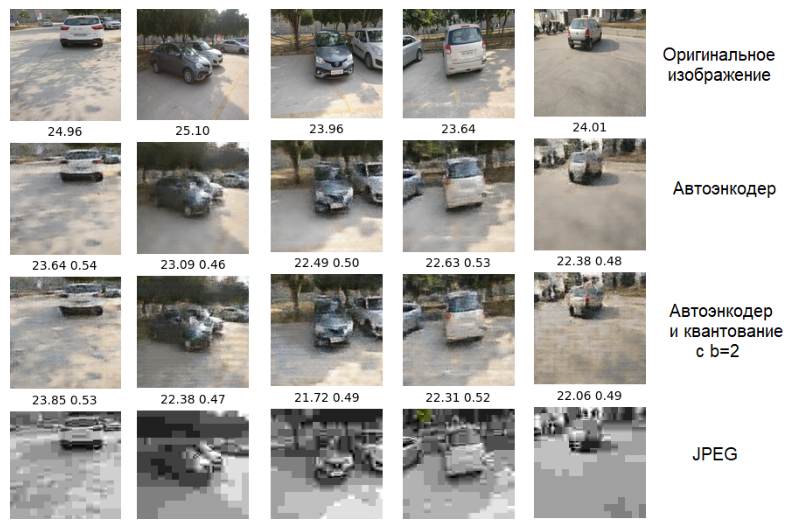

In [363]:
#!wget https://ctlab.itmo.ru/gitlab/eabelyaev/cnnimagecodec/-/raw/master/doc/AI_Epoch3000_Noisebt3.png
figsize = (10,15)
plt.figure(figsize=figsize)
plt.imshow(plt.imread('AI_Epoch3000_Noisebt3.png'))
plt.axis(False)
plt.show()

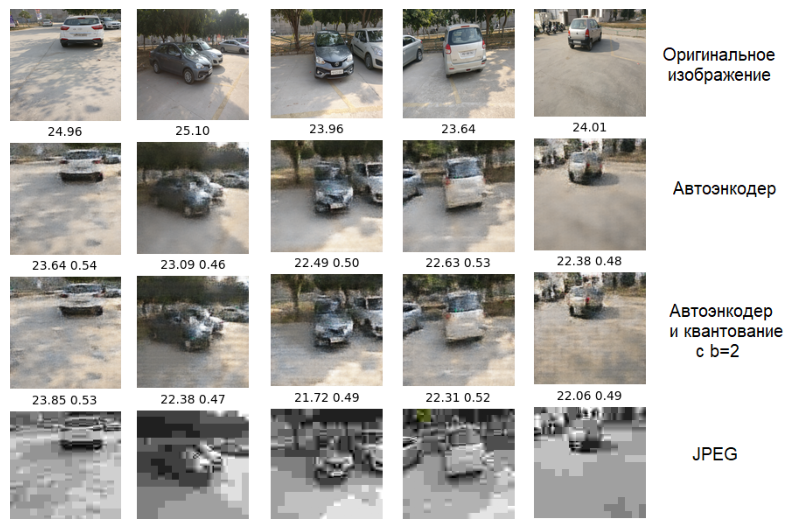

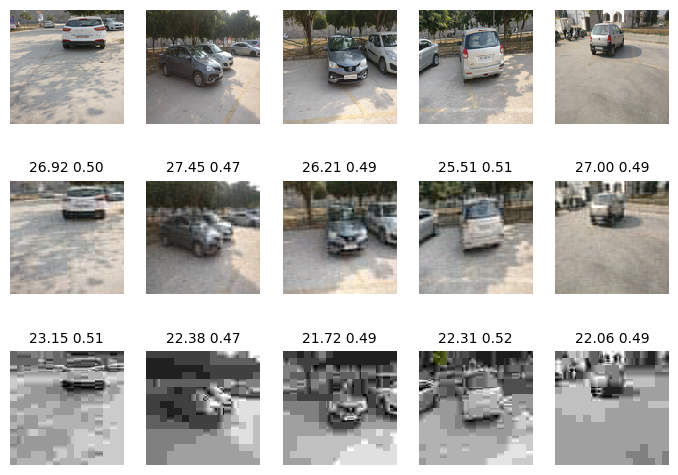